In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. CSV 파일 로드 및 'posts'와 'type' 열 가져오기
df = pd.read_csv(r'C:\Users\kdp\Desktop\KDW\EX_Deep_Learning\data\MBTI 500.csv', encoding='utf-8')

# P/J만 예측하기 위해 'P'와 'J'를 기준으로 라벨링
df['pj_type'] = df['type'].apply(lambda x: 1 if 'J' in x else 0)  # 'J'면 1, 'P'면 0
sampled_df = df.groupby('type', group_keys=False).apply(lambda x: x.sample(n=40, random_state=42))
sampled_df['type'].value_counts()
sampled_df['pj_type'] = sampled_df['type'].apply(lambda x: 1 if 'J' in x else 0) 
result = pd.DataFrame(columns=['posts','pj_type'] )
for index, row in sampled_df.iterrows():
    # 각 행의 단어를 분리
    features = row['posts'].split()
    # 해당 단어에 맞는 타겟 값 생성
    targets = [row['pj_type']] * len(features)

    # 결과 데이터프레임에 추가
    dfs = pd.DataFrame({'posts' : features, 'pj_type':targets})
    result = pd.concat([result, dfs], ignore_index=True)
# 텍스트와 라벨 데이터 준비
posts = df['posts'].values
labels = df['pj_type'].astype('float64').values
# 2. TF-IDF 벡터화
tfidf = TfidfVectorizer(max_features=5000)  # 최대 5000개의 단어만 사용
X = tfidf.fit_transform(posts)

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, labels, stratify=labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

# PyTorch 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train.toarray()).to(DEVICE)
X_test_tensor = torch.FloatTensor(X_test.toarray()).to(DEVICE)
y_train_tensor = torch.LongTensor(y_train).to(DEVICE)
y_test_tensor = torch.LongTensor(y_test).to(DEVICE)
x_v_tensor = torch.FloatTensor(X_val.toarray()).to(DEVICE)
y_v_tensor = torch.LongTensor(y_val).to(DEVICE)

## models 폴더 아래 프로젝트 폴더 아래 모델 파일저장
import os

# 저장 경로
SAVE_PATH = './models/mbti/'
# 저장 파일명
SAVE_FILE = 'model_train_wbs.pth'
# 저장 모델구조 및 파라미터 모두 저장
SAVE_MODEL = 'pj_model.pth'

if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
# 4. 데이터셋 클래스 정의
class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# DataLoader 정의
train_dataset = MyDataset(X_train_tensor, y_train_tensor)
test_dataset = MyDataset(X_test_tensor, y_test_tensor)
val_dataset = MyDataset(x_v_tensor, y_v_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

# 5. MLP 모델 정의
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLPModel, self).__init__()

        # 은닉층들을 nn.ModuleList로 관리
        layers = []
        in_features = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())  # 활성화 함수로 ReLU 추가
            in_features = hidden_size  # 다음 레이어의 입력 크기는 현재 레이어의 출력 크기

        # Dropout과 마지막 출력층 추가
        layers.append(nn.Dropout(0.3))  # Dropout 추가
        layers.append(nn.Linear(in_features, output_size))

        self.network = nn.Sequential(*layers)  # Sequential로 레이어 묶음

    def forward(self, x):
        return self.network(x)

# 입력 크기는 TF-IDF 벡터 차원인 5000으로 설정
input_size = 5000
hidden_sizes = [1000, 500, 300, 100, 50]
output_size = 1  # 이진 분류

model = MLPModel(input_size, hidden_sizes, output_size)
model.to(DEVICE)
# 6. 손실 함수 및 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 분류를 위한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 7. 모델 학습
epochs = 100
patience = 10  # 성능 향상이 없을 때 5번의 에포크 후 학습을 중단

best_loss = float('inf')  # 초기값을 매우 큰 값으로 설정
trigger_times = 0  # 개선되지 않은 에포크 수

LOSS_HISTORY, SCORE_HISTORY = [[],[]],[[],[]]
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    train_pred = []
    train_true = []
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features).view(-1)
        predicted = torch.round(torch.sigmoid(outputs))
        loss = criterion(outputs, targets.float())  # float형으로 변환
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        train_pred.extend(predicted.detach().cpu().numpy())
        train_true.extend(targets.detach().cpu().numpy())

    train_f1 = f1_score(train_pred, train_true)
    avg_loss_train = epoch_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss_train:.4f}, F1: {train_f1:.4f}')

    LOSS_HISTORY[0].append(avg_loss_train)
    SCORE_HISTORY[0].append(train_f1)

    # 8. 교차검증
    model.eval()
    v_pred = []
    v_true = []
    v_loss = 0
    with torch.no_grad():
        for features, targets in val_loader:
            outputs = model(features).view(-1)
            predicted = torch.round(torch.sigmoid(outputs))
            v_pred.extend(predicted.cpu().numpy())
            v_true.extend(targets.cpu().numpy())
            loss = criterion(outputs, targets.float())
            v_loss += loss.item()

        val_f1 = f1_score(train_pred, train_true)
        avg_loss_val = epoch_loss / len(train_loader)

        LOSS_HISTORY[1].append(avg_loss_val)
        SCORE_HISTORY[1].append(val_f1)

    # 조기종료 적용
    if avg_loss_train < best_loss:
        best_loss = avg_loss_train  
        BREAK_CNT = 0  # 성능이 개선된 경우 카운트를 초기화
    else:
        BREAK_CNT += 1  # 성능이 개선되지 않은 경우 카운트 증가
        print(f"{BREAK_CNT} epochs 개선효과 없음")

    if BREAK_CNT >= patience:
        print(f"{epoch+1} epoch에 학습 종료")
        break  

    if len(SCORE_HISTORY[1]) == 1:
        # 첫번째라서 무조건 모델 파라미터 저장
        torch.save(model.state_dict(),SAVE_PATH+SAVE_FILE)
        # 모델 전체 저장
        torch.save(model,SAVE_PATH+SAVE_MODEL)
    else:
        if SCORE_HISTORY[1][-1] >= max(SCORE_HISTORY[1]):
            # torch.save(model.state_dict(),f'{SAVE_PATH}{SAVE_FILE}_{epoch}_{LOSS_HISTORY[1][-1]}')
            torch.save(model.state_dict(),SAVE_PATH+SAVE_FILE)
            # 모델 전체 저장
            torch.save(model,SAVE_PATH+SAVE_MODEL)

# 9. 모델 평가
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features).view(-1)
        predicted = torch.round(torch.sigmoid(outputs))  # 시그모이드 함수로 확률 변환
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(targets.cpu().numpy())

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')


Epoch [1/100], Loss: 0.4041, F1: 0.7609
Epoch [2/100], Loss: 0.3088, F1: 0.8472
Epoch [3/100], Loss: 0.2471, F1: 0.8824
Epoch [4/100], Loss: 0.1071, F1: 0.9584
Epoch [5/100], Loss: 0.0346, F1: 0.9877
Epoch [6/100], Loss: 0.0126, F1: 0.9953
Epoch [7/100], Loss: 0.0097, F1: 0.9968
Epoch [8/100], Loss: 0.0061, F1: 0.9978
Epoch [9/100], Loss: 0.0063, F1: 0.9977
1 epochs 개선효과 없음
Epoch [10/100], Loss: 0.0047, F1: 0.9983
Epoch [11/100], Loss: 0.0043, F1: 0.9985
Epoch [12/100], Loss: 0.0043, F1: 0.9984
1 epochs 개선효과 없음
Epoch [13/100], Loss: 0.0026, F1: 0.9991
Epoch [14/100], Loss: 0.0050, F1: 0.9982
1 epochs 개선효과 없음
Epoch [15/100], Loss: 0.0043, F1: 0.9984
2 epochs 개선효과 없음
Epoch [16/100], Loss: 0.0037, F1: 0.9988
3 epochs 개선효과 없음
Epoch [17/100], Loss: 0.0032, F1: 0.9990
4 epochs 개선효과 없음
Epoch [18/100], Loss: 0.0021, F1: 0.9992
Epoch [19/100], Loss: 0.0023, F1: 0.9991
1 epochs 개선효과 없음
Epoch [20/100], Loss: 0.0023, F1: 0.9992
2 epochs 개선효과 없음
Epoch [21/100], Loss: 0.0020, F1: 0.9992
Epoch [22/10

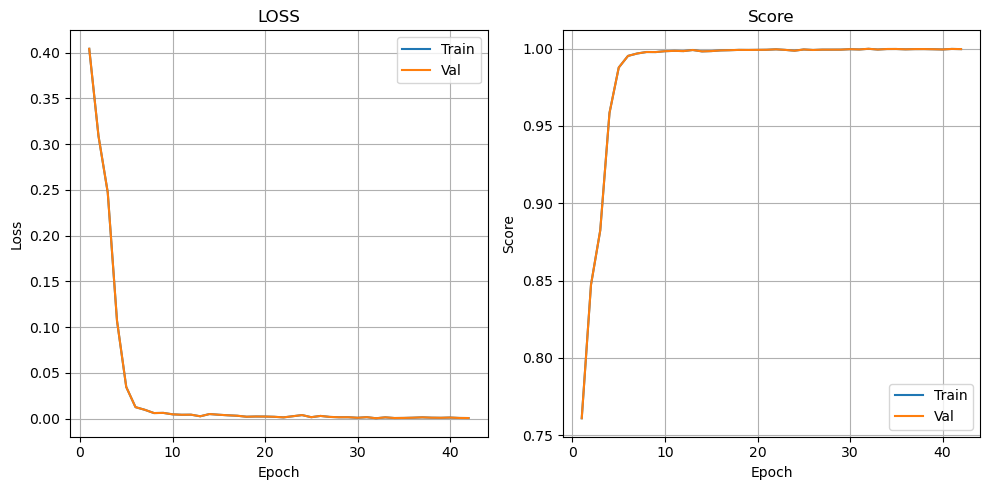

In [3]:
import matplotlib.pyplot as plt

TH=len(SCORE_HISTORY[1])

fg, axes=plt.subplots(1,2, figsize=(10,5), sharex=True)
axes[0].plot(range(1, TH+1), LOSS_HISTORY[0][:TH], label='Train')
axes[0].plot(range(1, TH+1), LOSS_HISTORY[1][:TH], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LOSS")

axes[1].plot(range(1, TH+1), SCORE_HISTORY[0][:TH], label='Train')
axes[1].plot(range(1, TH+1), SCORE_HISTORY[1][:TH], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Score")
axes[1].set_title("Score")
plt.tight_layout()
plt.show()# import matplotlib.pyplot as plt

